# Exercise 4

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [47]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """

    # use_cuda
    if use_cuda:
        model.cuda()

        
    # TODO: set the model to train mode
    model.train()
    
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        
        # TODO: run the network
        output = model(data)

        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        
        # TODO: do backpropagation
        loss.backward()

        
        # TODO: optimize
        optimizer.step()
       
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [48]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()


## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [49]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)  # Input: 784, Output: 200
        self.fc2 = nn.Linear(200, 100) # Input: 200, Output: 100
        self.fc3 = nn.Linear(100, 60)  # Input: 100, Output: 60
        self.fc4 = nn.Linear(60, 30)   # Input: 60, Output: 30
        self.fc5 = nn.Linear(30, 10)   # Input: 30, Output: 10
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        
        # TODO: run network layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = F.sigmoid(self.fc5(x))


        
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        
        return output
    



In [50]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()

        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        

    def forward(self, x):
        x = x.view(-1, 784)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        output = F.log_softmax(x, dim=1)

        return output

In [51]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()

        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        
    def forward(self, x):
        # add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)
        x = x.view(-1, 784)

        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.bn2(x)
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        output = F.log_softmax(x, dim=1)

        return output


## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [69]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10

    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)    
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))



        
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64*12*12)


        
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    

       
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        
        
        return output

In [70]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

        

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output

In [53]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)
        


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        output = F.log_softmax(x, dim=1)

        return output



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314906
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.162798
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.036645
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.034186
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.018679
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.032383
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.045360
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.018686
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.098042
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.060404

Test set: Average loss: 0.0482, Accuracy: 9840/10000 (98.40%)



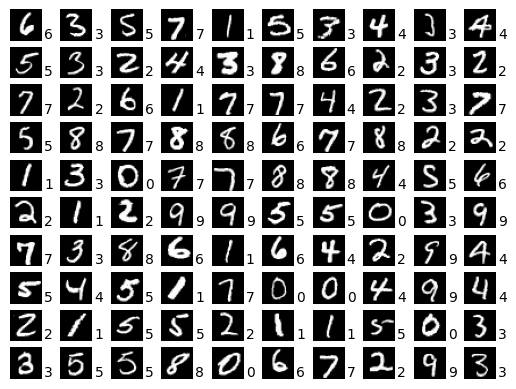

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.080061
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.119147
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.002459
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.004746
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.001009
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.016660
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.006124
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.054093
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.001278
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.005918

Test set: Average loss: 0.0318, Accuracy: 9896/10000 (98.96%)



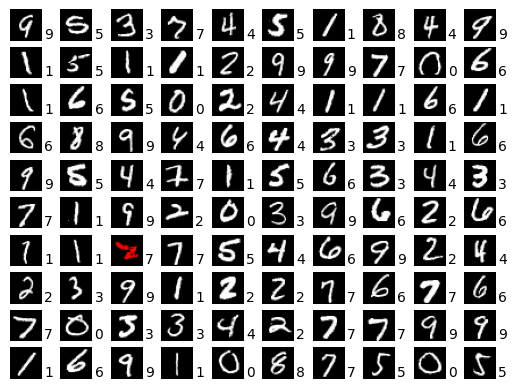

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.033588
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.024001
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.041278
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.007831
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.011714
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000878
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.039909
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.009722
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.008939
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.001856

Test set: Average loss: 0.0284, Accuracy: 9905/10000 (99.05%)



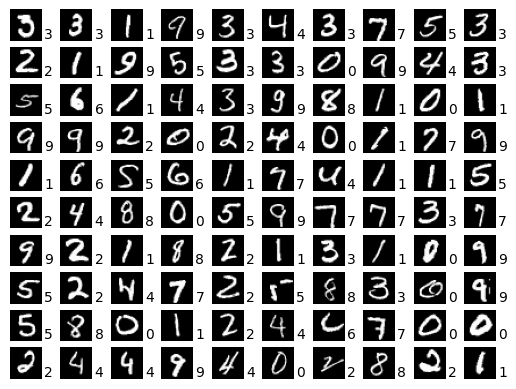

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001036
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.015688
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000064
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.070613
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000188
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001848
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000299
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001493
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.002478
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.005821

Test set: Average loss: 0.0291, Accuracy: 9918/10000 (99.18%)



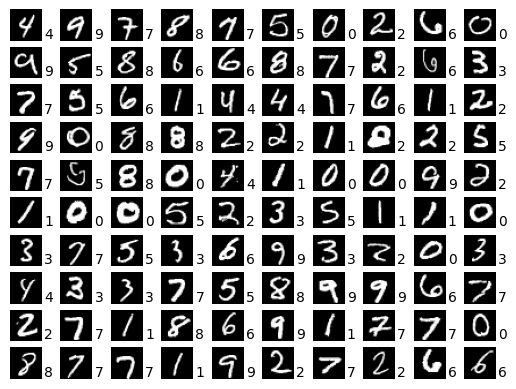

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000110
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.011232
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000244
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000676
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000394
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000149
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000617
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000214
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000948
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000660

Test set: Average loss: 0.0301, Accuracy: 9924/10000 (99.24%)



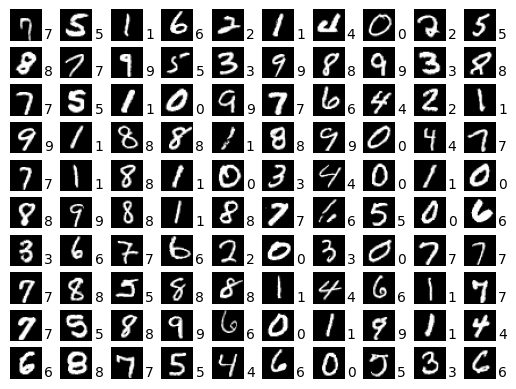

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000433
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.007252
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000685
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000380
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000628
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001016
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000101
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000046
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000140
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000536

Test set: Average loss: 0.0317, Accuracy: 9926/10000 (99.26%)



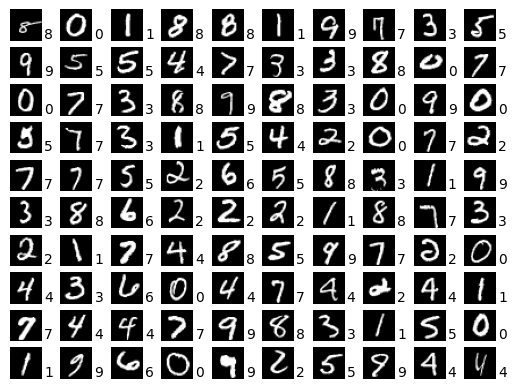

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000059
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000052
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000016
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000101
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000442
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.003443
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000927
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000857
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000334
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001738

Test set: Average loss: 0.0332, Accuracy: 9916/10000 (99.16%)



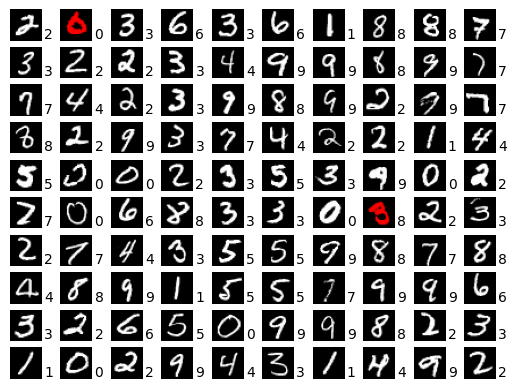

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000102
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001049
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000657
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000105
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.004707
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000053
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000732
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000004
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.001360
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000496

Test set: Average loss: 0.0336, Accuracy: 9921/10000 (99.21%)



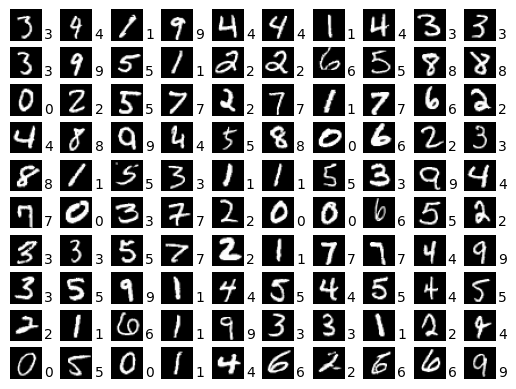

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000247
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000357
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000094
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000133
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.002406
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000276
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000188
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000097
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000413
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000008

Test set: Average loss: 0.0339, Accuracy: 9922/10000 (99.22%)



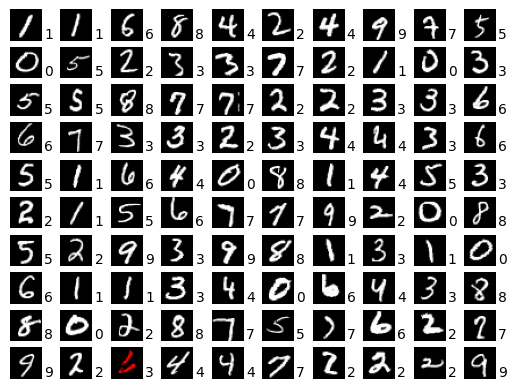

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000272
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000047
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000241
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000352
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000008
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000103
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000057
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.001352
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000779
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000018

Test set: Average loss: 0.0340, Accuracy: 9917/10000 (99.17%)



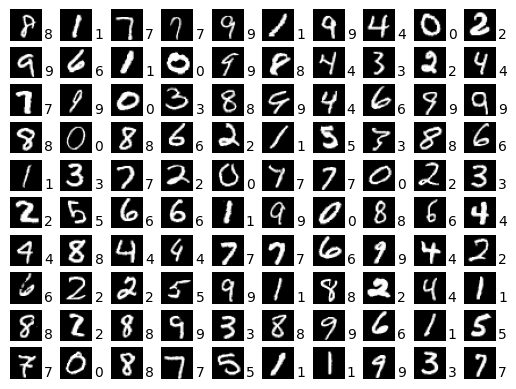

In [71]:

    

# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100


# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)



model = ConvNet1()

if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epochx      
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")